In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import sph_harm
from scipy.integrate import quad, dblquad

import numpy as np
import trimesh as tri
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sys
import os
import six

sys.path.insert(0,"../")
import pyssht

In [2]:
from utils import brownian_motion, sph_utils, mesh_processing

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Spherical decomposition and reconstruction tools

In [3]:
from scipy.special import sph_harm
import scipy.integrate as integrate

### Example

WARNING - 2022-09-20 17:14:00,822 - image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
WARNING - 2022-09-20 17:14:00,843 - image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.11801923541125048


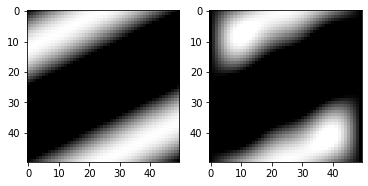

In [4]:
def f(theta, phi):
    return np.sin(theta + phi)

my_basis = sph_utils.SphHarmBasis(n_coeffs=25)

# encode your function in the desired basis and record the coefficients
my_coeffs = my_basis.sph_harm_transform(f)

# reconstruct your function at a point
point = (np.pi/8, np.pi/8)
my_basis.sph_harm_reconstruct(my_coeffs)(*point), f(*point)
my_reconstr_function = my_basis.sph_harm_reconstruct(my_coeffs)

pts_phi = np.linspace(0, 2*np.pi)
pts_theta = np.linspace(0, np.pi)
pts_2d = np.reshape(np.stack(np.meshgrid(pts_theta,pts_phi), axis=-1), (-1, 2))

actual = []
approx = []

pts_total = 0

for n, pt in enumerate(pts_2d):
    f_actual = f(*pt)
    f_approx = my_reconstr_function(*pt)
    
    actual.append(f_actual)
    approx.append(f_approx)

    pts_total += abs(f_approx - f_actual)
    
print(pts_total / len(pts_2d))

plt.subplot(121)
plt.imshow(np.reshape(np.repeat(actual, 3), (50, 50, 3)))

plt.subplot(122)
plt.imshow(np.reshape(np.repeat(approx, 3), (50, 50, 3)))
plt.show()

### For shapes (test with the 2-sphere)

In [5]:
def my_sphere_function_r(theta, phi):
    return np.array([1.0 for t in range(np.array(theta).size)])

def my_sphere_function_theta(theta, phi):
    return theta

def my_sphere_function_phi(theta, phi):
    return phi

def my_sphere_function_x(theta, phi):
    return np.sin(theta)*np.cos(phi)

def my_sphere_function_y(theta, phi):
    return np.sin(theta)*np.sin(phi)

def my_sphere_function_z(theta, phi):
    return np.cos(theta)

In [6]:
sphere = tri.creation.uv_sphere(count=[32, 32])
x, y ,z = np.array(sphere.vertices[:,0]), np.array(sphere.vertices[:,1]), np.array(sphere.vertices[:,2])
(r, theta, phi) = pyssht.cart_to_spherical(x, y, z)

In [7]:
f_actual_x = my_sphere_function_x(theta,phi)
f_actual_y = my_sphere_function_y(theta,phi)
f_actual_z = my_sphere_function_z(theta,phi)

In [8]:
f_actual_r = my_sphere_function_r(theta,phi)
f_actual_theta = my_sphere_function_theta(theta,phi)
f_actual_phi = my_sphere_function_phi(theta,phi)

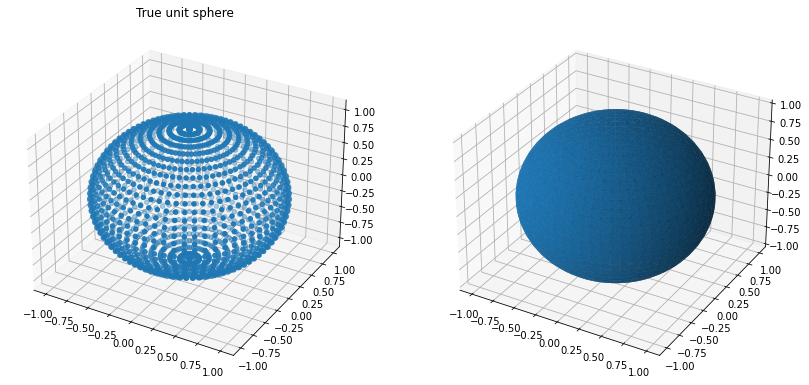

In [9]:
#(x_coord, y_coord, z_coord) = pyssht.spherical_to_cart(f_actual_r, f_actual_theta, f_actual_phi)
(x_coord, y_coord, z_coord) = f_actual_x, f_actual_y, f_actual_z
mesh = tri.convex.convex_hull(np.array([x_coord, y_coord, z_coord]).T)

fig = plt.figure(figsize=(14,14))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(x_coord, y_coord, z_coord)
ax1.set_title("True unit sphere")

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_trisurf(mesh.vertices[:, 0], mesh.vertices[:,1], triangles=mesh.faces, Z=mesh.vertices[:,2])

plt.show()

In [10]:
my_basis = sph_utils.SphHarmBasis(n_coeffs=25) # NEED TO BE A SQUARE NUMBER

my_coeffs_r = my_basis.sph_harm_transform(my_sphere_function_r)
my_coeffs_theta = my_basis.sph_harm_transform(my_sphere_function_theta)
my_coeffs_phi = my_basis.sph_harm_transform(my_sphere_function_phi)

my_coeffs_x = my_basis.sph_harm_transform(my_sphere_function_x)
my_coeffs_y = my_basis.sph_harm_transform(my_sphere_function_y)
my_coeffs_z = my_basis.sph_harm_transform(my_sphere_function_z)

my_reconstr_function_r = my_basis.sph_harm_reconstruct(my_coeffs_r)
my_reconstr_function_theta = my_basis.sph_harm_reconstruct(my_coeffs_theta)
my_reconstr_function_phi = my_basis.sph_harm_reconstruct(my_coeffs_phi)

my_reconstr_function_x = my_basis.sph_harm_reconstruct(my_coeffs_x)
my_reconstr_function_y = my_basis.sph_harm_reconstruct(my_coeffs_y)
my_reconstr_function_z = my_basis.sph_harm_reconstruct(my_coeffs_z)

In [11]:
f_recons_r = my_reconstr_function_r(theta,phi)
f_recons_theta = my_reconstr_function_theta(theta,phi)
f_recons_phi = my_reconstr_function_phi(theta,phi)

f_recons_x = my_reconstr_function_x(theta,phi)
f_recons_y = my_reconstr_function_y(theta,phi)
f_recons_z = my_reconstr_function_z(theta,phi)

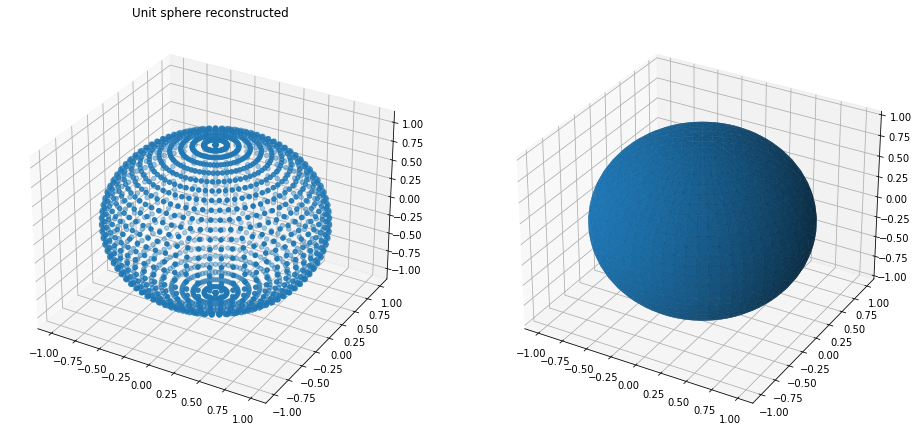

In [12]:
(x_coord_recons, y_coord_recons, z_coord_recons) = pyssht.spherical_to_cart(f_recons_r, f_recons_theta, f_recons_phi)
(x_coord_recons, y_coord_recons, z_coord_recons) = f_recons_x, f_recons_y, f_recons_z
mesh_recons = tri.convex.convex_hull(np.array([x_coord_recons, y_coord_recons, z_coord_recons]).T)

fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(x_coord_recons, y_coord_recons, z_coord_recons)
ax1.set_title("Unit sphere reconstructed")

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_trisurf(mesh_recons.vertices[:, 0], mesh_recons.vertices[:,1], triangles=mesh_recons.faces, Z=mesh_recons.vertices[:,2])
plt.show()

Imprecision on the borders of $[0, \pi] \times [0, 2 \pi]$ !!!

# Brownian motion on the basis

In [13]:
def my_sphere_function_r(theta, phi):
    return np.array([1.0 for t in range(np.array(theta).size)])

def my_sphere_function_theta(theta, phi):
    return theta

def my_sphere_function_phi(theta, phi):
    return phi

def my_sphere_function_x(theta, phi):
    return np.sin(theta)*np.cos(phi)

def my_sphere_function_y(theta, phi):
    return np.sin(theta)*np.sin(phi)

def my_sphere_function_z(theta, phi):
    return np.cos(theta)

N = 32
sphere = tri.creation.uv_sphere(count=[N, N])
x, y ,z = np.array(sphere.vertices[:,0]), np.array(sphere.vertices[:,1]), np.array(sphere.vertices[:,2])
(r, theta, phi) = pyssht.cart_to_spherical(x, y, z)

In [14]:
n = 25 ## NEED TO BE A SQUARE NUMBER
my_basis = sph_utils.SphHarmBasis(n_coeffs=n)
x = np.linspace(0, np.max((n,N)), np.max((n,N)))
lambdas = np.where(abs(x)<=16, 1, 0)
Q = np.eye(n) #covariance operator
#Q = np.eye(n)
t = 1

f_actual_r = my_sphere_function_r(theta,phi)
f_actual_theta = my_sphere_function_theta(theta,phi)
f_actual_phi = my_sphere_function_phi(theta,phi)

my_coeffs_x = my_basis.sph_harm_transform(my_sphere_function_x)
my_coeffs_y = my_basis.sph_harm_transform(my_sphere_function_y)
my_coeffs_z = my_basis.sph_harm_transform(my_sphere_function_z)

my_reconstr_function_x = my_basis.sph_harm_reconstruct(my_coeffs_x)
my_reconstr_function_y = my_basis.sph_harm_reconstruct(my_coeffs_y)
my_reconstr_function_z = my_basis.sph_harm_reconstruct(my_coeffs_z)

f_recons_x = my_reconstr_function_x(theta,phi)
f_recons_y = my_reconstr_function_y(theta,phi)
f_recons_z = my_reconstr_function_z(theta,phi)

my_reconstr_stoch_r = my_basis.sph_harm_reconstruct_random(my_coeffs_r, Q, t, theta = theta, phi = phi, n_step = 10)[2]
my_reconstr_stoch_theta = my_basis.sph_harm_reconstruct_random(my_coeffs_theta, Q, t, theta = theta, phi = phi, n_step = 10)[2]
my_reconstr_stoch_phi = my_basis.sph_harm_reconstruct_random(my_coeffs_phi, Q, t, theta = theta, phi = phi, n_step = 10)[2]

my_reconstr_stoch_x = my_basis.sph_harm_reconstruct_random(my_coeffs_x, Q, t, theta = theta, phi = phi, n_step = 10)[2]
my_reconstr_stoch_y = my_basis.sph_harm_reconstruct_random(my_coeffs_y, Q, t, theta = theta, phi = phi, n_step = 10)[2]
my_reconstr_stoch_z = my_basis.sph_harm_reconstruct_random(my_coeffs_z, Q, t, theta = theta, phi = phi, n_step = 10)[2]

f_stoch_x = my_reconstr_stoch_x
f_stoch_y = my_reconstr_stoch_y
f_stoch_z = my_reconstr_stoch_z

In [15]:
(x_coord, y_coord, z_coord) = f_actual_x, f_actual_y, f_actual_z
mesh = tri.convex.convex_hull(np.array([x_coord, y_coord, z_coord]).T)
(x_coord_recons, y_coord_recons, z_coord_recons) = f_recons_x, f_recons_y, f_recons_z
mesh_recons = tri.convex.convex_hull(np.array([x_coord_recons, y_coord_recons, z_coord_recons]).T)

(x_coord_stoch, y_coord_stoch, z_coord_stoch) = f_stoch_x, f_stoch_y, f_stoch_z
mesh_stoch = tri.convex.convex_hull(np.array([x_coord_stoch, y_coord_stoch, z_coord_stoch]).T)

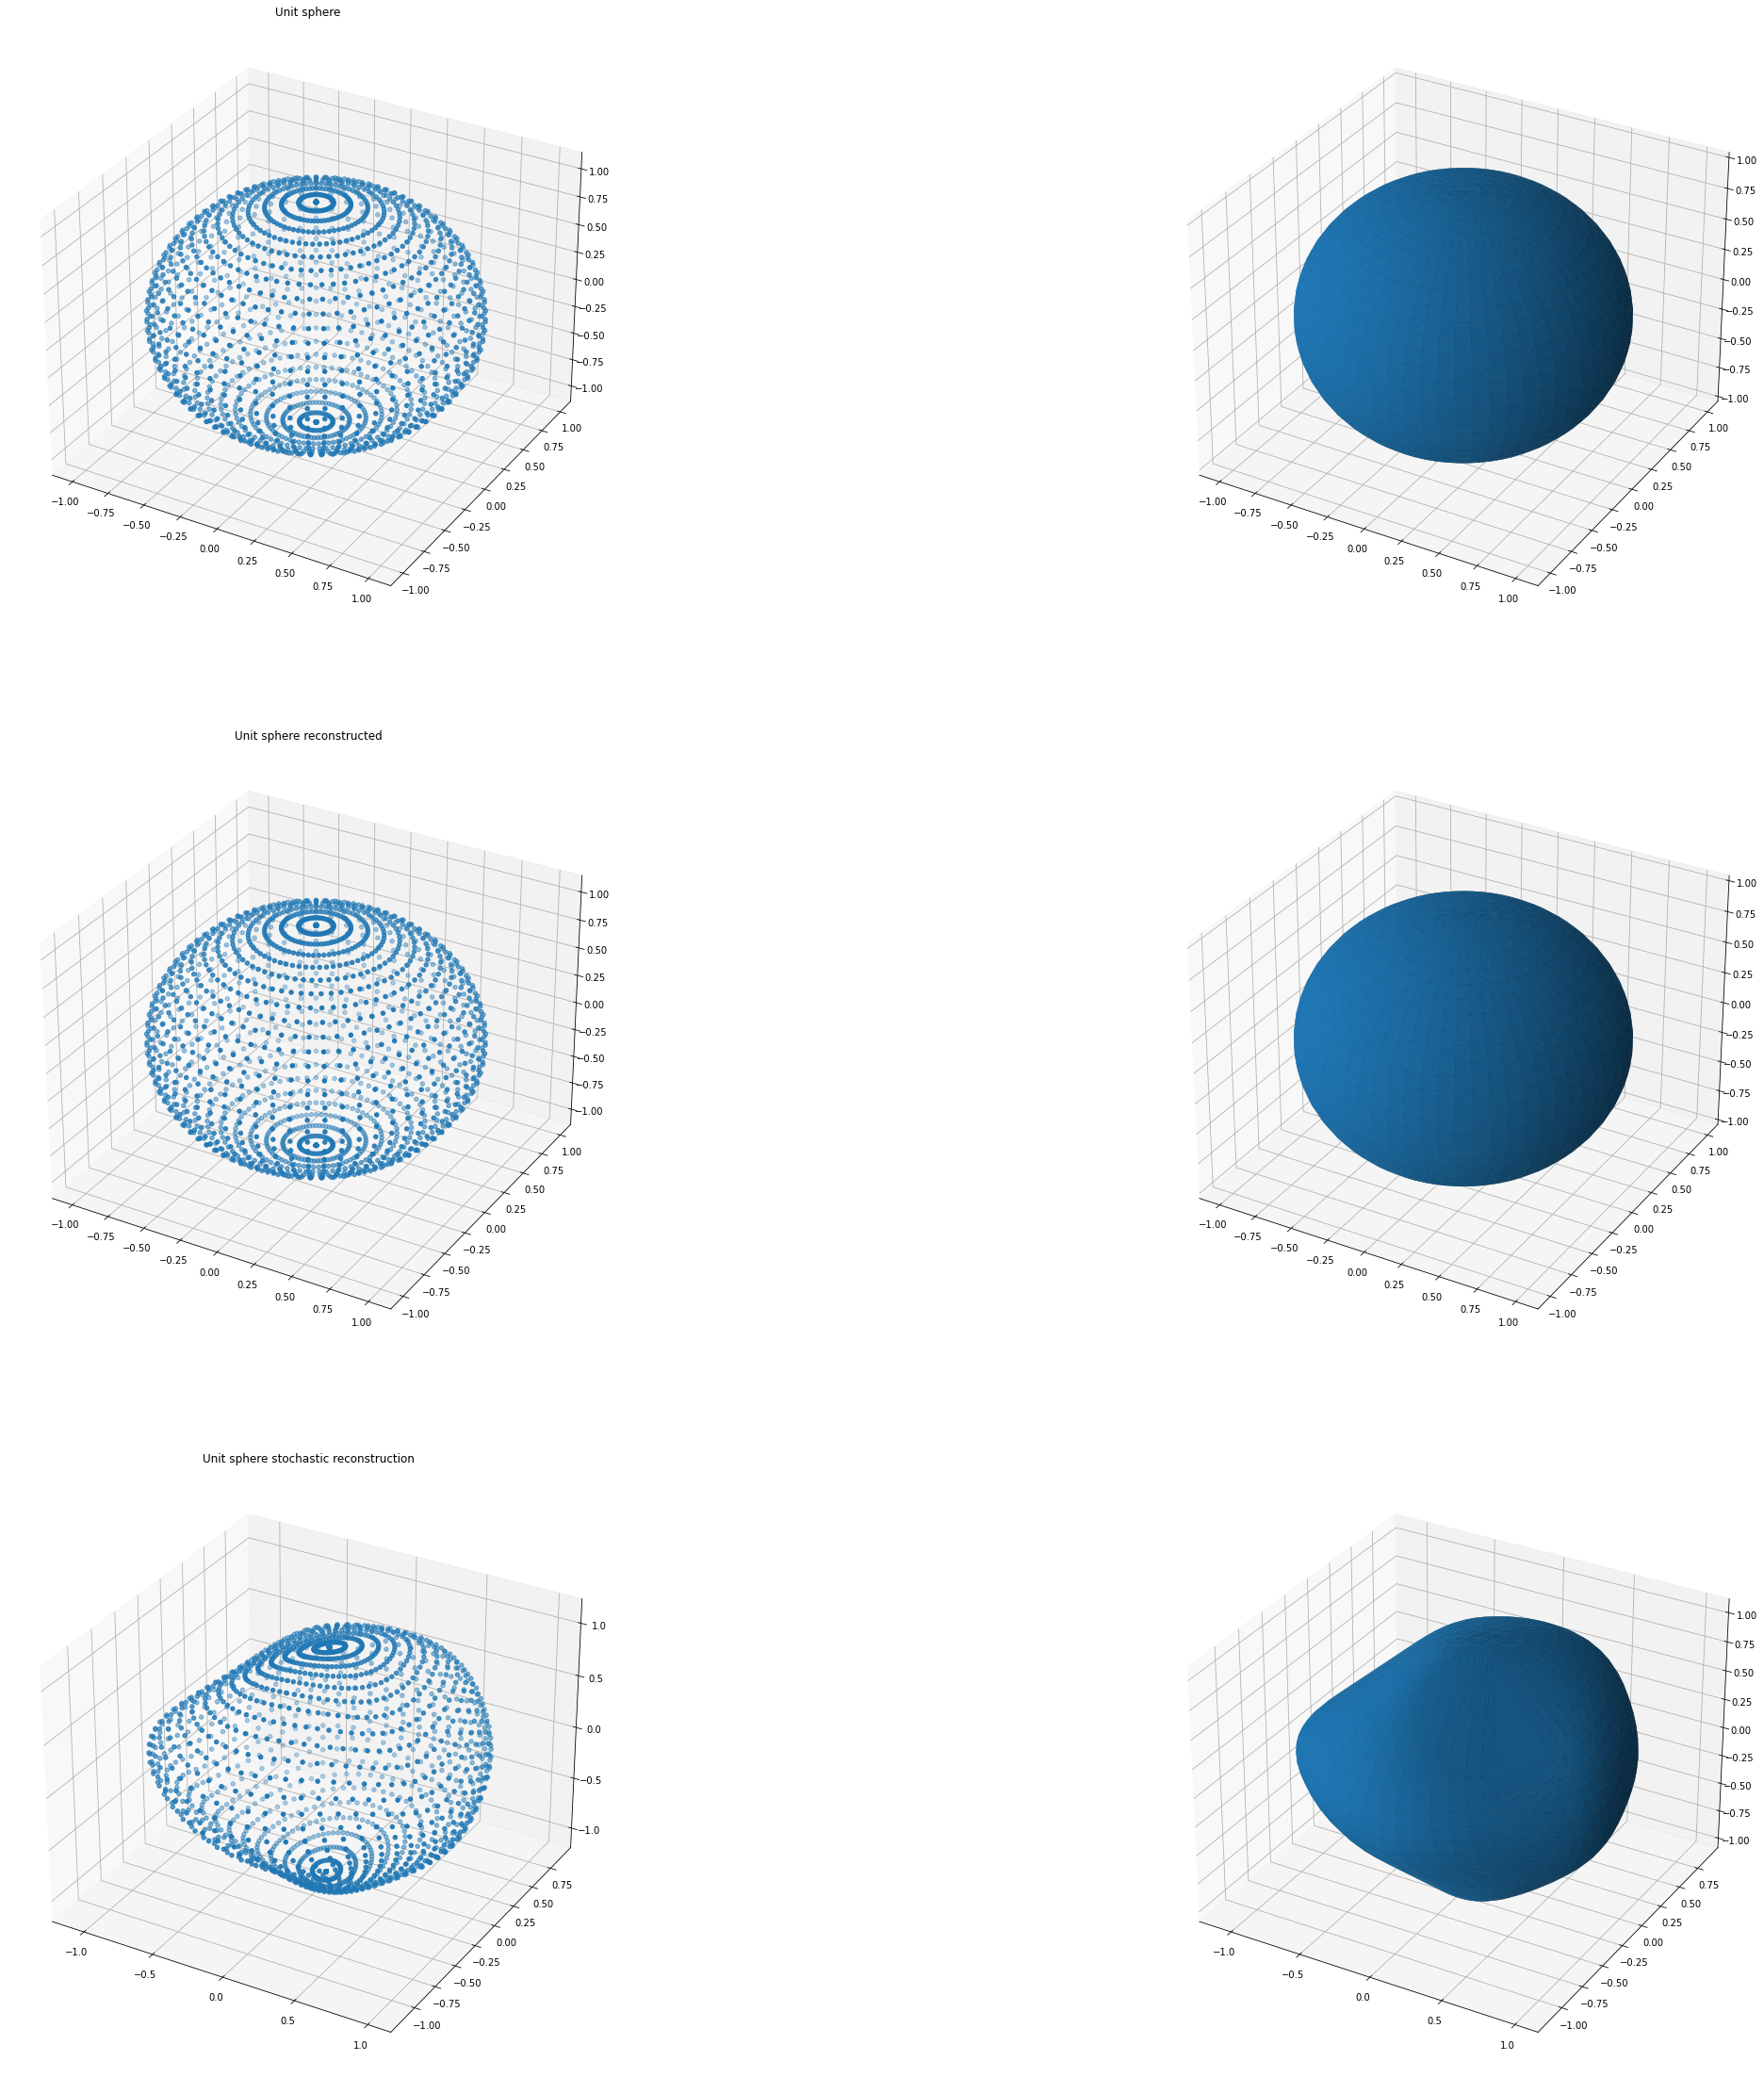

In [16]:
fig = plt.figure(figsize=(40,40))
ax1 = fig.add_subplot(321, projection='3d')
ax1.scatter(x_coord, y_coord, z_coord)
ax1.set_title("Unit sphere")

ax2 = fig.add_subplot(322, projection='3d')
ax2.plot_trisurf(sphere.vertices[:, 0], sphere.vertices[:,1], triangles=sphere.faces, Z=sphere.vertices[:,2])

ax3 = fig.add_subplot(323, projection='3d')
ax3.scatter(x_coord_recons, y_coord_recons, z_coord_recons)
ax3.set_title("Unit sphere reconstructed")

ax4 = fig.add_subplot(324, projection='3d')
ax4.plot_trisurf(mesh_recons.vertices[:, 0], mesh_recons.vertices[:,1], triangles=mesh_recons.faces, Z=mesh_recons.vertices[:,2])

ax5 = fig.add_subplot(325, projection='3d')
ax5.scatter(x_coord_stoch, y_coord_stoch, z_coord_stoch)
ax5.set_title("Unit sphere stochastic reconstruction")

ax6 = fig.add_subplot(326, projection='3d')
ax6.plot_trisurf(mesh_stoch.vertices[:, 0], mesh_stoch.vertices[:,1], triangles=mesh_stoch.faces, Z=mesh_stoch.vertices[:,2])

plt.show()

### Sequence

In [17]:
N = 32
n = 100
sphere = tri.creation.uv_sphere(count=[N, N])
x, y ,z = np.array(sphere.vertices[:,0]), np.array(sphere.vertices[:,1]), np.array(sphere.vertices[:,2])
(r, theta, phi) = pyssht.cart_to_spherical(x, y, z)
my_basis = sph_utils.SphHarmBasis(n_coeffs=n)

t = 10
listpq = []

def my_sphere_function_x(theta, phi):
    return np.sin(theta)*np.cos(phi)

def my_sphere_function_y(theta, phi):
    return np.sin(theta)*np.sin(phi)

def my_sphere_function_z(theta, phi):
    return np.cos(theta)

x = np.linspace(0, n, n)
#lambdas = np.where(abs(x)<=100, 1, 0)
lambdas = np.array([1/(np.sqrt(k+1)) for k in range (0,n)])
#lambdas = np.array([np.exp(-k) for k in range (0,n)])
Q = np.diag(lambdas) #covariance operator

Q = np.eye(n)

In [18]:
my_coeffs_x = my_basis.sph_harm_transform(my_sphere_function_x)
my_coeffs_y = my_basis.sph_harm_transform(my_sphere_function_y)
my_coeffs_z = my_basis.sph_harm_transform(my_sphere_function_z)

my_reconstr_function_x = my_basis.sph_harm_reconstruct(my_coeffs_x)
my_reconstr_function_y = my_basis.sph_harm_reconstruct(my_coeffs_y)
my_reconstr_function_z = my_basis.sph_harm_reconstruct(my_coeffs_z)

f_recons_x = my_reconstr_function_x(theta,phi)
f_recons_y = my_reconstr_function_y(theta,phi)
f_recons_z = my_reconstr_function_z(theta,phi)
    
#my_reconstr_stoch_r = my_basis.sph_harm_reconstruct_random(my_coeffs_r, Q, t, theta = theta, phi = phi, n_step = 200)
#my_reconstr_stoch_theta = my_basis.sph_harm_reconstruct_random(my_coeffs_theta, Q, t, theta = theta, phi = phi, n_step = 200)
#my_reconstr_stoch_phi = my_basis.sph_harm_reconstruct_random(my_coeffs_phi, Q, t, theta = theta, phi = phi, n_step = 200)

my_reconstr_stoch_x = my_basis.sph_harm_reconstruct_random(my_coeffs_x, Q, t, theta = theta, phi = phi, n_step = 100)
my_reconstr_stoch_y = my_basis.sph_harm_reconstruct_random(my_coeffs_y, Q, t, theta = theta, phi = phi, n_step = 100)
my_reconstr_stoch_z = my_basis.sph_harm_reconstruct_random(my_coeffs_z, Q, t, theta = theta, phi = phi, n_step = 100)

In [19]:
f_stoch_x = my_reconstr_stoch_x
f_stoch_y = my_reconstr_stoch_y
f_stoch_z = my_reconstr_stoch_z

for t in range(f_stoch_x.shape[0]):
    (x_coord_stoch, y_coord_stoch, z_coord_stoch) = f_stoch_x[t], f_stoch_y[t], f_stoch_z[t]
    listpq.append([x_coord_stoch, y_coord_stoch, z_coord_stoch])
        
listpq = np.array(listpq)

In [20]:
rows_unique = np.unique(listpq[0,:,:].T, axis=0, return_index=True)
new = listpq[0,:,:].T[rows_unique[1]]
hull = tri.convex.convex_hull(new, qhull_options='QbB Pp Qt QJ')
faces = hull.faces

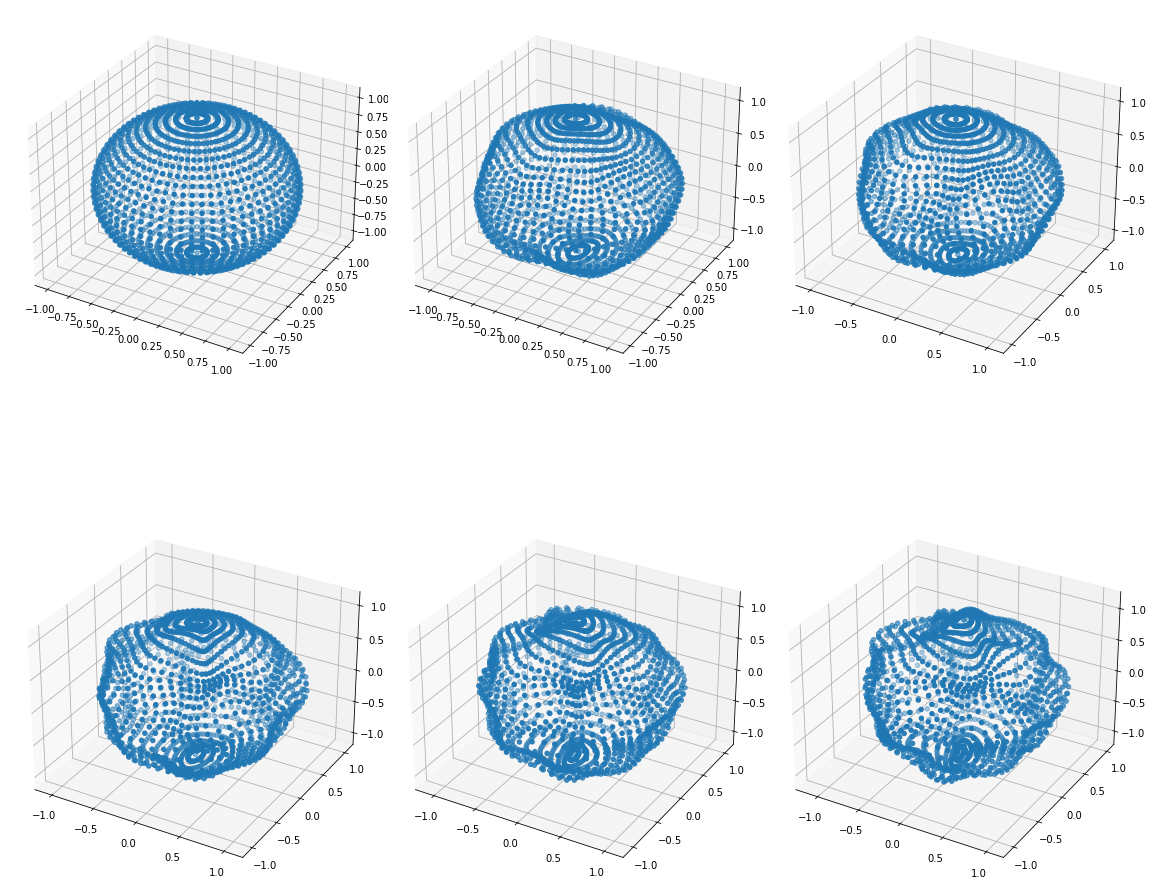

In [21]:
fig = plt.figure(figsize=(16,16))

ax1 = fig.add_subplot(231, projection='3d')
ax1.scatter(listpq[0,:,:].T[rows_unique[1]][:,0], listpq[0,:,:].T[rows_unique[1]][:,1], listpq[0,:,:].T[rows_unique[1]][:,2])

ax2 = fig.add_subplot(232, projection='3d')
ax2.scatter(listpq[1,:,:].T[rows_unique[1]][:,0], listpq[1,:,:].T[rows_unique[1]][:,1], listpq[1,:,:].T[rows_unique[1]][:,2])

ax3 = fig.add_subplot(233, projection='3d')
ax3.scatter(listpq[2,:,:].T[rows_unique[1]][:,0], listpq[2,:,:].T[rows_unique[1]][:,1], listpq[2,:,:].T[rows_unique[1]][:,2])

ax4 = fig.add_subplot(234, projection='3d')
ax4.scatter(listpq[3,:,:].T[rows_unique[1]][:,0], listpq[3,:,:].T[rows_unique[1]][:,1], listpq[3,:,:].T[rows_unique[1]][:,2])

ax5 = fig.add_subplot(235, projection='3d')
ax5.scatter(listpq[4,:,:].T[rows_unique[1]][:,0], listpq[4,:,:].T[rows_unique[1]][:,1], listpq[4,:,:].T[rows_unique[1]][:,2])

ax6 = fig.add_subplot(236, projection='3d')
ax6.scatter(listpq[5,:,:].T[rows_unique[1]][:,0], listpq[5,:,:].T[rows_unique[1]][:,1], listpq[5,:,:].T[rows_unique[1]][:,2])

plt.tight_layout()
plt.show()

In [22]:
steps = []
for i in range(listpq.shape[0]):
    steps.append(listpq[i,:,:].T[rows_unique[1]])
steps = np.array(steps)

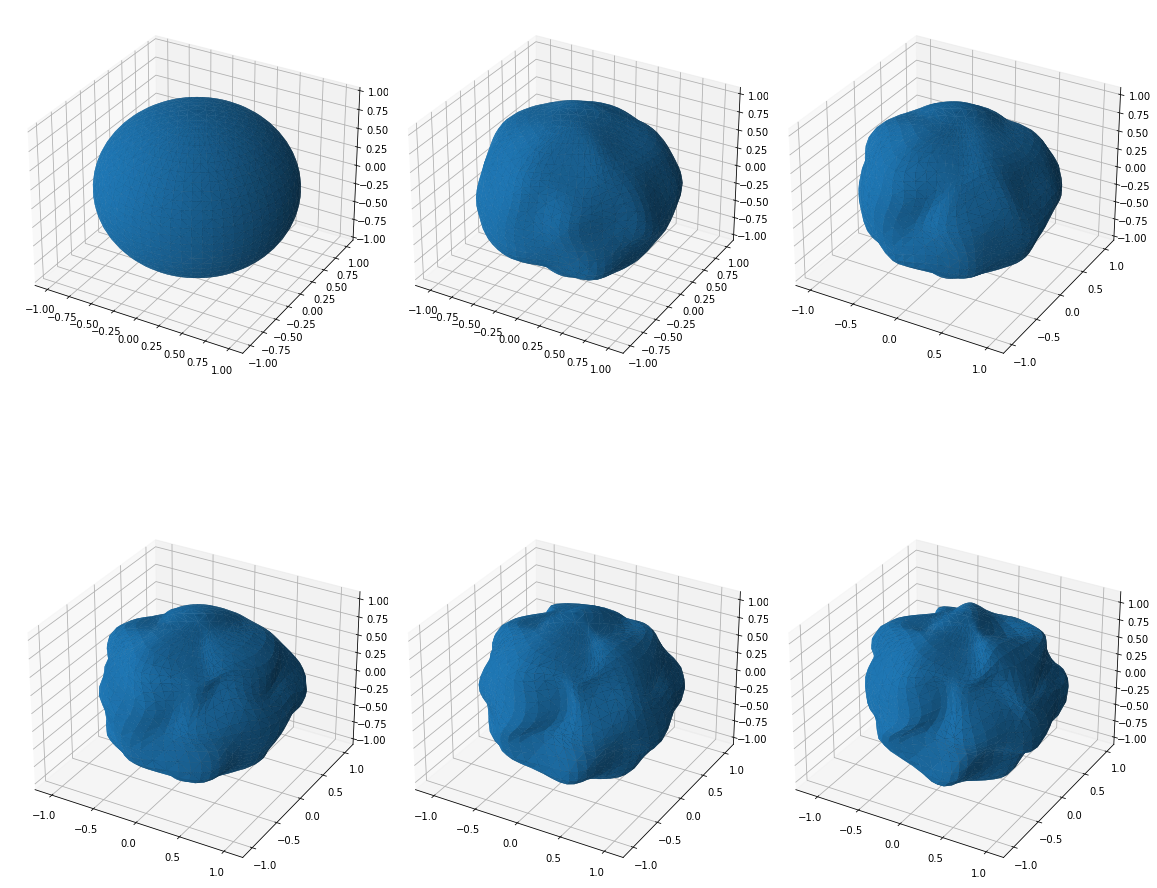

In [23]:
fig = plt.figure(figsize=(16,16))

ax1 = fig.add_subplot(231, projection='3d')
ax1.plot_trisurf(listpq[0,:,:].T[rows_unique[1]][:,0], listpq[0,:,:].T[rows_unique[1]][:,1], triangles=faces, Z=listpq[0,:,:].T[rows_unique[1]][:,2])

ax2 = fig.add_subplot(232, projection='3d')
ax2.plot_trisurf(listpq[1,:,:].T[rows_unique[1]][:,0], listpq[1,:,:].T[rows_unique[1]][:,1], triangles=faces, Z=listpq[1,:,:].T[rows_unique[1]][:,2])

ax3 = fig.add_subplot(233, projection='3d')
ax3.plot_trisurf(listpq[2,:,:].T[rows_unique[1]][:,0], listpq[2,:,:].T[rows_unique[1]][:,1], triangles=faces, Z=listpq[2,:,:].T[rows_unique[1]][:,2])

ax4 = fig.add_subplot(234, projection='3d')
ax4.plot_trisurf(listpq[3,:,:].T[rows_unique[1]][:,0], listpq[3,:,:].T[rows_unique[1]][:,1], triangles=faces, Z=listpq[3,:,:].T[rows_unique[1]][:,2])

ax5 = fig.add_subplot(235, projection='3d')
ax5.plot_trisurf(listpq[4,:,:].T[rows_unique[1]][:,0], listpq[4,:,:].T[rows_unique[1]][:,1], triangles=faces, Z=listpq[4,:,:].T[rows_unique[1]][:,2])

ax6 = fig.add_subplot(236, projection='3d')
ax6.plot_trisurf(listpq[5,:,:].T[rows_unique[1]][:,0], listpq[5,:,:].T[rows_unique[1]][:,1], triangles=faces, Z=listpq[5,:,:].T[rows_unique[1]][:,2])

plt.tight_layout()
plt.show()

## Stochastic deformation of the sphere animation

In [24]:
mesh_processing.create_gif(listpq, "tests/wiener_process_new", "Q_identity_100coeffs.gif", auto_scale = True)